## Part 1 - Dealing with Missing Data


**Notice: This notebook is a modification of [sniff.ipynb](https://mlbook.explained.ai/notebooks/index.html) by Terence Parr and Jeremy Howard, which was used by permission of the author.**

Please use this notebook to follow along with the lectures this week. Feel free to modify the code in any way. 

There may be minor differences between the notebook seen in the lecture videos and this one. 

In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from rfpimp import * 

We will use slightly modified versions of the `evaluate` and `showimp` functions from the last few notebooks. 

In [2]:
def evaluate(X, y, n_estimators=50):
    rf = RandomForestRegressor(n_estimators=n_estimators, n_jobs=-1, oob_score=True)
    rf.fit(X, y)
    oob = rf.oob_score_
    n = rfnnodes(rf)
    h = np.median(rfmaxdepths(rf))
    print(f"OOB R^2 is {oob:.5f} using {n:,d} tree nodes with {h} median tree depth")
    return rf, oob

In [3]:
def showimp(rf, X, y):
    features = list(X.columns)
    I = importances(rf, X, y, features=features)
    plot_importances(I, color='#4575b4')

### Read in the Data

To prep the data for loading, please refer to [Section 7.1](https://mlbook.explained.ai/bulldozer-intro.html#sec:7.1) of *The Mechanics of Machine learning*. Once we have the data in the proper format, we are going to read it in and make a copy. Making a copy is a good idea as then we will always have the original data available without having to reload it. 

In [4]:
# Data must be logged in to get. Download Train.zip from:
# https://www.kaggle.com/c/bluebook-for-bulldozers/data
# Uncompress to get Train.csv, then run this program in same dir as that Train.csv
# to get bulldozer-train.feature which is much faster to load.
# python prep-bulldozer.py 
!pip install pyarrow
import pyarrow
import pandas as pd
import csv
import os


if not (os.path.isfile('Train.csv') and os.path.isfile('Valid.csv') and os.path.isfile('ValidSolution.csv')):
    print("Can't find Train.csv or Valid.csv or ValidSolution.csv file; must execute this program in same dir")
    print("To get these files, go to https://www.kaggle.com/c/bluebook-for-bulldozers/data")
    exit()

dtypes = {col:str for col in ['fiModelSeries', 'Coupler_System', 'Grouser_Tracks', 'Hydraulics_Flow']}
df = pd.read_csv('Train.csv', dtype=dtypes, parse_dates=['saledate']) # 35s load
df = df.sort_values('saledate')
df = df.reset_index(drop=True)

df.to_feather("bulldozer-train-all.feather")
print("Created bulldozer-train-all.feather")

# Split out validation set and make training/validation sets
n_valid = 12000  # same as Kaggle's test set size
n_train = len(df)-n_valid
df_train = df[:n_train].reset_index(drop=True)
df_valid = df[n_train:].reset_index(drop=True)
df_train.to_feather("bulldozer-train.feather")
print("Created bulldozer-train.feather")
df_valid.to_feather("bulldozer-valid.feather")
print("Created bulldozer-valid.feather")

# Read Kaggle validation / solution and make it our test set
df_test = pd.read_csv("Valid.csv", dtype=dtypes, parse_dates=['saledate'])
df_test = df_test.sort_values('saledate')
df_test_soln = pd.read_csv("ValidSolution.csv")
df_test_soln['SalePrice'] = df_test_soln['SalePrice'].astype(int)
del df_test_soln['Usage']
df_merged = df_test.merge(df_test_soln, on='SalesID', how='left') # merge in solution
df_merged.to_feather("bulldozer-test.feather")
print("Created bulldozer-test.feather")

Created bulldozer-train-all.feather
Created bulldozer-train.feather
Created bulldozer-valid.feather
Created bulldozer-test.feather


In [5]:
df_raw = pd.read_feather("bulldozer-train.feather")
df = df_raw.copy()

Now let's see how much data we are dealing wih:

In [6]:
df.shape

(389125, 53)

And get an idea of what it looks like:

In [7]:
df.head().T

,0,1,2,3,4
SalesID,1646770,1404019,1415646,1596358,1821514
SalePrice,9500,24000,35000,19000,14000
MachineID,1126363,1169900,1262088,1433229,1194089
ModelID,8434,7110,3357,8247,10150
datasource,132,132,132,132,132
auctioneerID,18.0,99.0,99.0,99.0,99.0
YearMade,1974,1986,1975,1978,1980
MachineHoursCurrentMeter,NaN,NaN,NaN,NaN,NaN
UsageBand,None,None,None,None,None
saledate,1989-01-17 00:00:00,1989-01-31 00:00:00,1989-01-31 00:00:00,1989-01-31 00:00:00,1989-01-31 00:00:00


Let's get a bit more information on the data so we can start planning what we need to do. To do this, we will use the following function:

In [8]:
def sniff_modified(df):
    with pd.option_context("display.max_colwidth", 20):
        info = pd.DataFrame()
        info['data type'] = df.dtypes
        info['percent missing'] = df.isnull().sum()*100/len(df)
        info['No. unique'] = df.apply(lambda x: len(x.unique()))
        info['unique values'] = df.apply(lambda x: x.unique())
        return info.sort_values('data type')

In [9]:
sniff_modified(df)

,data type,percent missing,No. unique,unique values
SalesID,int64,0.000000,389125,"[1646770, 1404019, 1415646, 1596358, 1821514, ..."
SalePrice,int64,0.000000,878,"[9500, 24000, 35000, 19000, 14000, 22500, 3100..."
MachineID,int64,0.000000,332365,"[1126363, 1169900, 1262088, 1433229, 1194089, ..."
ModelID,int64,0.000000,5154,"[8434, 7110, 3357, 8247, 10150, 7267, 7620, 41..."
datasource,int64,0.000000,5,"[132, 136, 121, 172, 149]"
YearMade,int64,0.000000,71,"[1974, 1986, 1975, 1978, 1980, 1976, 1987, 197..."
auctioneerID,float64,5.174687,31,"[18.0, 99.0, 4.0, 1.0, 6.0, 24.0, 19.0, 10.0, ..."
MachineHoursCurrentMeter,float64,64.717764,14527,"[nan, 1640.0, 1400.0, 2249.0, 729.0, 1237.0, 4..."
saledate,datetime64[ns],0.000000,3816,"[1989-01-17T00:00:00.000000000, 1989-01-31T00:..."
Coupler,object,46.826855,4,"[None, None or Unspecified, Manual, Hydraulic]"


### Quickly get a Baseline Model

As we did before, we need to specify our target (`SalePrice`) and then focus in on the numeric data and create and evaluate a baseline model. That means we will consider only these features for now: `SalesID`, `MachineID`, `ModelID`, `datasource`, `YearMade`, `auctioneerID`, and `MachineHoursCurrentMeter`. 

However, as seen above, the last two contain missing values, so we will have to deal with that in order to create a model. 

Remember that we need two things to train a model:
- all numeric data
- no missing values

In [10]:
basefeatures = ['SalesID', 'MachineID', 'ModelID',
                'datasource', 'YearMade',
                'auctioneerID', 'MachineHoursCurrentMeter']

In [11]:
X = df[basefeatures]
y = df['SalePrice']

X = X.fillna(0)

In [12]:
%%time
rf, oob_baseline_initial = evaluate(X, y, n_estimators=100)

OOB R^2 is 0.78674 using 44,996,442 tree nodes with 55.0 median tree depth
Wall time: 1min 11s


In [13]:
%%time
rf, oob_baseline_initial = evaluate(X, y, n_estimators=50)

OOB R^2 is 0.78106 using 22,496,952 tree nodes with 54.0 median tree depth
Wall time: 40.5 s


To speed up the training time even further, we will only work with a portion of the data: 100,000 samples. If the data had no time sensitivity, then we would take a random sample. Since we have time sensitive data we will take the last 100,000 samples as more recent data should be better at predicting near future sale prices, since we know that prices can change over time due to inflation, etc. 

In [14]:
df = df.iloc[-100000:]

In [15]:
X = df[basefeatures]
y = df['SalePrice']

X = X.fillna(0)

In [16]:
%%time
rf, oob_baseline_initial = evaluate(X, y, n_estimators=50)

OOB R^2 is 0.84546 using 5,556,902 tree nodes with 46.0 median tree depth
Wall time: 9.29 s


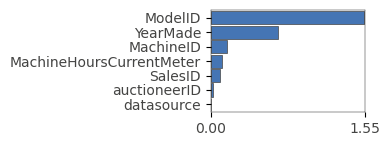

In [17]:
showimp(rf, X, y)

### Cleaning up the Data

In order to try to improve our model performance (which may or may not be possible) we will clean up our data with the following procedure:
- Drop features that have no predictive value or have known problems that can't be fixed;
- Convert actual categorical features from current numeric data type to an object data type;
- normalize the representation of missing data;
- clean up strings that are actually numeric; 
- extract features;
- encode categorical features; 
- deal with missing data. 

#### Removing Features

Let's start with features we can get rid of: 

- `SalesID` can be deleted as it is a unique identifier, that is, each row in the data has a unique value for `SalesID` so our model will not be able to use this to help it generalize; 
- `MachineID` should be deleted as it can be shown to have inconsistencies and errors, as in the same `MachineID` showing up as being manufactured in many different years (see link in [Section 7.4](https://mlbook.explained.ai/bulldozer-intro.html#sec:7.4) for details).  

In [18]:
df.drop(['SalesID', 'MachineID'], axis=1, inplace=True)
df.columns

Index(['SalePrice', 'ModelID', 'datasource', 'auctioneerID', 'YearMade',
       'MachineHoursCurrentMeter', 'UsageBand', 'saledate', 'fiModelDesc',
       'fiBaseModel', 'fiSecondaryDesc', 'fiModelSeries', 'fiModelDescriptor',
       'ProductSize', 'fiProductClassDesc', 'state', 'ProductGroup',
       'ProductGroupDesc', 'Drive_System', 'Enclosure', 'Forks', 'Pad_Type',
       'Ride_Control', 'Stick', 'Transmission', 'Turbocharged',
       'Blade_Extension', 'Blade_Width', 'Enclosure_Type', 'Engine_Horsepower',
       'Hydraulics', 'Pushblock', 'Ripper', 'Scarifier', 'Tip_Control',
       'Tire_Size', 'Coupler', 'Coupler_System', 'Grouser_Tracks',
       'Hydraulics_Flow', 'Track_Type', 'Undercarriage_Pad_Width',
       'Stick_Length', 'Thumb', 'Pattern_Changer', 'Grouser_Type',
       'Backhoe_Mounting', 'Blade_Type', 'Travel_Controls',
       'Differential_Type', 'Steering_Controls'],
      dtype='object')

#### Convert DataType

Sometimes what are really categorical variables show up in our data as numeric, so we need to figure out how to handle these situations. Of our original numeric data, it seems that we have a few that are categorical:

- `ModelID` is a nominal categorical feature but it is already encoded as a number and has no missing values so we will leave it as it is;
- `datasource` is a nominal categorical feature but it is already encoded as a number and has no missing values so we will leave it as it is;
- `auctioneerID` is a nominal categorical feature and since it has missing values we will convert this to an *object* data type and deal with it when we handle categorical encoding and missing values.

So, for now we will simply convert `auctioneerID` from numeric to string data type. 

In [19]:
df['auctioneerID'] = df['auctioneerID'].astype(str)

#### What does *missing* mean?

The concept of missing is not usually straightforward so you will have to do some digging into the data to see what you find. 

In [20]:
missing = pd.DataFrame({'colour':['Unspecified', 'red', None, '', 'None', 'yellow'], 'width':[ 12, -1, '', 14, 999, np.nan]})
missing

,colour,width
0,Unspecified,12
1,red,-1
2,None,
3,,14
4,None,999
5,yellow,NaN


In [21]:
missing.isnull()

,colour,width
0,False,False
1,False,False
2,True,False
3,False,False
4,False,False
5,False,True


#### How Missing is Represented in Our Data

Let's see how missing values are showing up in our data:

In [22]:
df['Drive_System'].unique()

array([None, 'Two Wheel Drive', 'Four Wheel Drive', 'No',
       'All Wheel Drive'], dtype=object)

In [23]:
df['Backhoe_Mounting'].unique()

array(['None or Unspecified', None, 'Yes'], dtype=object)

In [24]:
df['fiModelSeries'].unique()

array([None, 'LC', 'III', 'II', '-12', '-5', 'V', '-7', '-21', '-2', '-8',
       '6.00E+00', '6', '-2N', 'IV', '-1', '-3LK', '-3PT', '-6',
       '7.00E+00', '-3MC', '7', '-15', '15', '-3', '-3LC', '5', '-5L',
       '-20', '-1L', '-6E', 'XT', '8', '3', '-18', '-3L', 'VHP', '5N',
       'ZTS', 'A', '22', '-5H', '2', '-6K', '1', '-2C', '2B', '-3EO',
       'SeriesII', '-7E', 'LT', '-16', '17', 'IV-2', '-4', '2T', '-6LC',
       'XLT', '18', '#NAME?', 'D', 'E', '6F', '-21A', ' III', '-7K',
       'FASTRRACK', 'GALEO', '-5LC', '-1.50E+01', 'TC', '20', 'L', '-6A',
       '16', 'V-2', '21KomStat', '6LE', '-5E', '-3H', '7A', '12', '-6C',
       '-17', '3C', '-7B', 'ZHS', '3A', 'WX', 'LGP', '-6LK', 'AWS', '6LK',
       '14FT', '6L', '-3C', 'Elite', 'Q', '-1B', 'EX', 'VI', '4', 'H',
       'LV', '21KomStatII', '7L', '-11'], dtype=object)

#### Normalize the Representation of Missing Values

It will be much easier to handle if we convert all the different ways this data has to signal missing data down to a single representation: `np.nan`. To do this we will use the following function which: 
- converts all strings (text) to lower case;
- fill actual missing data with `np.nan`; the impact of this is to convert `None` to `np.nan`;
- convert all the other representations ('none', 'none or unspecified', '#name?', and '') to `np.nan`.

In [25]:
from pandas.api.types import is_string_dtype, is_object_dtype

def df_normalize_strings(df):
    for col in df.columns:
        if is_string_dtype(df[col]) or is_object_dtype(df[col]):
            df[col] = df[col].str.lower() # lower case
            df[col] = df[col].fillna(np.nan) # replacing na with np.nan
            df[col] = df[col].replace('none or unspecified', np.nan)
            df[col] = df[col].replace('none', np.nan)
            df[col] = df[col].replace('#name?', np.nan)
            df[col] = df[col].replace('', np.nan)

In [26]:
df_normalize_strings(df)

In [27]:
df['Drive_System'].unique()

array([nan, 'two wheel drive', 'four wheel drive', 'no',
       'all wheel drive'], dtype=object)

In [28]:
df['Backhoe_Mounting'].unique()

array([nan, 'yes'], dtype=object)

In [29]:
df['fiModelSeries'].unique()

array([nan, 'lc', 'iii', 'ii', '-12', '-5', 'v', '-7', '-21', '-2', '-8',
       '6.00e+00', '6', '-2n', 'iv', '-1', '-3lk', '-3pt', '-6',
       '7.00e+00', '-3mc', '7', '-15', '15', '-3', '-3lc', '5', '-5l',
       '-20', '-1l', '-6e', 'xt', '8', '3', '-18', '-3l', 'vhp', '5n',
       'zts', 'a', '22', '-5h', '2', '-6k', '1', '-2c', '2b', '-3eo',
       'seriesii', '-7e', 'lt', '-16', '17', 'iv-2', '-4', '2t', '-6lc',
       'xlt', '18', 'd', 'e', '6f', '-21a', ' iii', '-7k', 'fastrrack',
       'galeo', '-5lc', '-1.50e+01', 'tc', '20', 'l', '-6a', '16', 'v-2',
       '21komstat', '6le', '-5e', '-3h', '7a', '12', '-6c', '-17', '3c',
       '-7b', 'zhs', '3a', 'wx', 'lgp', '-6lk', 'aws', '6lk', '14ft',
       '6l', '-3c', 'elite', 'q', '-1b', 'ex', 'vi', '4', 'h', 'lv',
       '21komstatii', '7l', '-11'], dtype=object)

#### Numeric Features Hiding as Strings

Some of the features that are being stored as strings are actually numeric: `TireSize`, `Undercarriage_Pad_Width`, `Blade_Width`, and `Stick_Length`. The first two are easier so let's look at them first.

In [30]:
df['Tire_Size'].unique()

array([nan, '26.5', '20.5', '17.5', '23.5', '14"', '13"', '29.5', '17.5"',
       '15.5"', '20.5"', '15.5', '23.5"', '7.0"', '10"', '23.1"'],
      dtype=object)

In [31]:
df['Undercarriage_Pad_Width'].unique()

array([nan, '36 inch', '24 inch', '20 inch', '34 inch', '26 inch',
       '30 inch', '28 inch', '32 inch', '16 inch', '31 inch', '18 inch',
       '22 inch', '33 inch', '14 inch', '27 inch', '25 inch', '15 inch'],
      dtype=object)

For these two we are going to: 
- extract numbers using a regular expression;
- replace any resulting missing value with `np.nan` (just in case);
- convert the column to numeric data type.

To see how regular expressions are going to work for us, let's use a toy dataframe. 

In [32]:
regexp = pd.DataFrame({'Tire_Size':['12', 'some text 14 some text', '13"', '12.5"']})
regexp

,Tire_Size
0,12
1,some text 14 some text
2,"13"""
3,"12.5"""


In [33]:
regexp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4 entries, 0 to 3
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Tire_Size  4 non-null      object
dtypes: object(1)
memory usage: 160.0+ bytes


Now let's use a regular expression to extract the types of numbers we expect to see in the `Tire_Size` feature. 


In [34]:
regexp['Tire_Size'] = regexp['Tire_Size'].str.extract('(\d+\.\d+|\d+)') 
regexp

,Tire_Size
0,12
1,14
2,13
3,12.5


In the `extract('(\d+\.\d+|\d+)')` code above we have the following basic elements:

- `\d+` to extract any sequence of digits (integers), e.g., '12', '123', '1234'; 
- `\.` to extract a literal decimal point '.'; and, 
- `|` is the OR operator. 

These basic elements are used in the following way: 
- `\d+\.\d+` to extract any sequence of one or more digits followed by a decimal point followed by another sequence of one or more digits; OR 
- `\d+` to extract any sequence of one or more digits when there is no decimal point. 

We should also notice that extract the numbers does not mean that the column has been converted to a numeric data type. So far, we have just cleaned up the strings that represent numbers so that all non-numeric characters (like " as the shorthand notation for inches) have been removed.  

In [35]:
regexp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4 entries, 0 to 3
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Tire_Size  4 non-null      object
dtypes: object(1)
memory usage: 160.0+ bytes


We need to explicitly convert the feature to a numeric data type:

In [36]:
regexp['Tire_Size'] = pd.to_numeric(regexp['Tire_Size'])
regexp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4 entries, 0 to 3
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Tire_Size  4 non-null      float64
dtypes: float64(1)
memory usage: 160.0 bytes


We will now create a function to do this for any feature:

In [37]:
def extract_sizes(df, colname):
    df[colname] = df[colname].str.extract('(\d+\.\d+|\d+)', expand=True)
    df[colname] = df[colname].replace('', np.nan)
    df[colname] = pd.to_numeric(df[colname])

We can now apply this function to `Tire_Size` and `Undercarriage_Pad_Width`. 

In [38]:
extract_sizes(df, 'Tire_Size')

In [39]:
extract_sizes(df, 'Undercarriage_Pad_Width')

Dealing with `Blade_Width` is a bit more complicated because of the `"<12'"` value:

In [40]:
df['Blade_Width'].unique()

array([nan, "12'", "14'", "13'", "16'", "<12'"], dtype=object)

There are a couple ways to approach this: 
- convert it into numeric form; or 
- consider this to be a categorical variable given the small number of unique values. 

This feature has missing values so we have to consider that as well. If we convert it to numeric we will end up replacing the missing values with a median value. And if we treat it as categorical, then the missing values will form their own category. 

We will treat this as a categorical variable but the next section shows how you could go about converting it to numeric if you chose to do that. 

##### Aside: convert `Blade_Width` to numeric

To demonstrate this will will use a toy dataset that consists of all the unique values found in our data. 

In [41]:
blade = pd.DataFrame({'width':[np.nan, "12'", "14'", "13'", "16'", "<12'"]})
blade

,width
0,NaN
1,12'
2,14'
3,13'
4,16'
5,<12'


Since there aren't that many unique values, we can create a mapping that directly converts all the values to their corresponding number. Here, I am grouping all the `"<12'"` under the number 11. This may not be ideal as that will impact the median value when we replace the missing values. 

In [42]:
blade['width'] = blade['width'].map({"NaN": np.nan, "12'":12, "13'": 13, "14'":14, "16'":16, "<12'":11})
blade

,width
0,NaN
1,12.0
2,14.0
3,13.0
4,16.0
5,11.0


In [43]:
blade.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6 entries, 0 to 5
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   width   5 non-null      float64
dtypes: float64(1)
memory usage: 176.0 bytes


`Stick_Length` is similar to `Blade_Width` and we could handle it in the same way. However, in this case I am going to try to convert it numeric `apply()` and a new function. Aside from the missing values, the entries for this feature all have the same structure: `'10\'6"'`. The outer quotations (' ') tell us this is a string, while the middle `\'` is a single literal quotation that is shorthand for the distance measurement of `feet` and the single " is shorthand for `inches`. 

The steps we'll need to take are: 
- extract the number for feet and the number for inches; 
- multiply the number of feet by 12 to convert to inches; and 
- add it to the number of inches. 
This will convert the `Stick_Length` feature to a numeric column where the unit of length is the inch. 

To see how this is going to work we will create a toy dataframe using the unique values for `Stick_Length`. 

In [44]:
stick = pd.DataFrame({'length': df['Stick_Length'].unique()})
                      
stick.head()

,length
0,NaN
1,"10' 6"""
2,"9' 6"""
3,"9' 7"""
4,"10' 2"""


In [45]:
stick.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25 entries, 0 to 24
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   length  24 non-null     object
dtypes: object(1)
memory usage: 328.0+ bytes


In [46]:
# modified version of: https://stackoverflow.com/questions/26986655/changing-height-feet-and-inches-to-an-integer-in-python-pandas

def parse_length(length):
    if length is not np.nan:
      split_length = length.split("' ")
      feet = float(split_length[0])
      inches = float(split_length[1].replace("\"",""))
      return (12*feet) + inches
    else:
      return np.nan

stick['length'] = stick["length"].apply(lambda x: parse_length(x))

In [47]:
stick.head()

,length
0,NaN
1,126.0
2,114.0
3,115.0
4,122.0


In [48]:
stick.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25 entries, 0 to 24
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   length  24 non-null     float64
dtypes: float64(1)
memory usage: 328.0 bytes


### Summary

It is a good time to recall everything that we have done so far. We have:

- dropped the `SalesID` and `MachineID` features;
- converted `auctioneerID` to 'string' data type so we can treat it as a categorical feature;
- decided to leave `Blade_Width` as 'string' and treat as a categorical feature instead of converting to numeric;
- extracted numeric features from the original `Undercarriage_Pad_Width` and `Tire_Size` strings;
- converted `Stick_Length` to a numeric feature from the original string representation;
- normalized the representation of missing values to `np.nan`.

Since this process gets messy and, at times, difficult to keep track of, let's reproduce everything we've done so we can see it all in one place. 

In [49]:
df = df_raw.copy()
df = df.iloc[-100000:]

In [50]:
df.drop(['SalesID', 'MachineID'], axis=1, inplace=True)
df['auctioneerID'] = df['auctioneerID'].astype(str)
df_normalize_strings(df)
extract_sizes(df, 'Tire_Size')
extract_sizes(df, 'Undercarriage_Pad_Width')
df['Stick_Length'] = df['Stick_Length'].apply(lambda x: parse_length(x))

In [51]:
sniff_modified(df)

,data type,percent missing,No. unique,unique values
SalePrice,int64,0.000,574,"[8300, 15500, 26000, 80000, 77500, 17750, 4900..."
ModelID,int64,0.000,3703,"[4663, 11859, 1133, 457, 3858, 4584, 2249, 340..."
datasource,int64,0.000,5,"[136, 132, 121, 172, 149]"
YearMade,int64,0.000,63,"[1985, 1995, 1997, 1993, 2000, 1999, 2005, 199..."
Tire_Size,float64,85.891,12,"[nan, 26.5, 20.5, 17.5, 23.5, 14.0, 13.0, 29.5..."
Stick_Length,float64,93.602,25,"[nan, 126.0, 114.0, 115.0, 122.0, 152.0, 154.0..."
saledate,datetime64[ns],0.000,674,"[2009-01-23T00:00:00.000000000, 2009-01-24T00:..."
Undercarriage_Pad_Width,float64,96.806,18,"[nan, 36.0, 24.0, 20.0, 34.0, 26.0, 30.0, 28.0..."
MachineHoursCurrentMeter,float64,20.955,13175,"[0.0, nan, 2301.0, 2132.0, 212.0, 301.0, 3187...."
Backhoe_Mounting,object,99.998,2,"[nan, yes]"
